# Prepare Dataset for Model Training and Evaluating

## Amazon Customer Reviews Dataset

https://s3.amazonaws.com/amazon-reviews-pds/readme.html

### Schema

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case digital videos).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.

In [30]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

## Download

Let's start by retrieving a subset of the Amazon Customer Reviews dataset.

You have to attach "AmazonS3FullAccess" to the Jupyter Notebook instance enable the next command

In [31]:
!aws s3 cp 's3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz' ./data/

download: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz to data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz


<img src="images/ClickNotebookServer.png" align="left" alt="ML Model" width = "400">

<img src="images/ClickARN.png" align="left" alt="ML Model" width = "400">

<img src="images/AttachS3policy.png" align="left" alt="ML Model" width = "400">

## Read in data into a Dataframe and determine shape

In [32]:
import csv

df = pd.read_csv('./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz', 
                 delimiter='\t', 
                 quoting=csv.QUOTE_NONE,
                 compression='gzip')
df.shape

(102084, 15)

## Read first few lines to what we're looking at

In [33]:
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4,0,0,N,Y,Four Stars,So far so good,2015-08-31
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,N,Y,Three Stars,Needs a little more work.....,2015-08-31
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1,1,2,N,Y,One Star,Please cancel.,2015-08-31
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,N,Y,Works as Expected!,Works as Expected!,2015-08-31
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31


## Plot current dataset

Text(0, 0.5, 'Review Count')

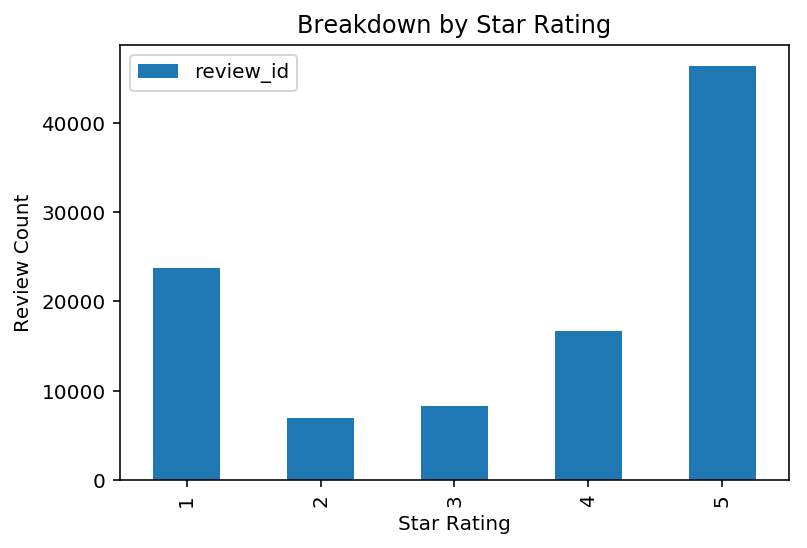

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

df[['star_rating', 'review_id']].groupby('star_rating').count().plot(kind='bar', title='Breakdown by Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Review Count')

## Balance the dataset

In [35]:
from sklearn.utils import resample

five_star_df = df.query('star_rating == 5')
four_star_df = df.query('star_rating == 4')
three_star_df = df.query('star_rating == 3')
two_star_df = df.query('star_rating == 2')
one_star_df = df.query('star_rating == 1')

# TODO:  check which sentiment has the least number of samples

five_star_df = resample(five_star_df,
                        replace = False,
                        n_samples = len(two_star_df),
                        random_state = 27)

four_star_df = resample(four_star_df,
                        replace = False,
                        n_samples = len(two_star_df),
                        random_state = 27)

three_star_df = resample(three_star_df,
                        replace = False,
                        n_samples = len(two_star_df),
                        random_state = 27)

two_star_df = resample(two_star_df,
                        replace = False,
                        n_samples = len(two_star_df),
                        random_state = 27)

one_star_df = resample(one_star_df,
                        replace = False,
                        n_samples = len(two_star_df),
                        random_state = 27)

df_balanced = pd.concat([five_star_df, four_star_df, three_star_df, two_star_df, one_star_df])
df_balanced = df_balanced.reset_index(drop=True)

Text(0, 0.5, 'Review Count')

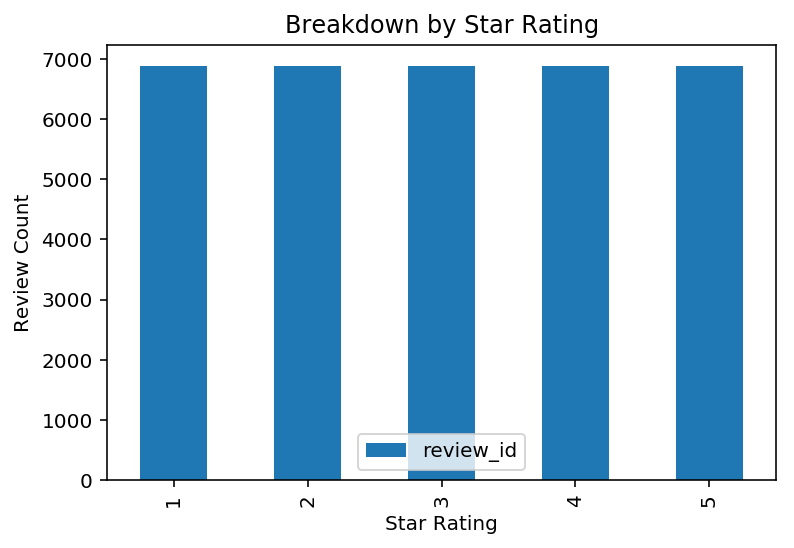

In [36]:
df_balanced[['star_rating', 'review_id']].groupby('star_rating').count().plot(kind='bar', title='Breakdown by Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Review Count')

In [37]:
df_train = df_balanced[['star_rating', 'review_body']]
df_train.shape

(34450, 2)

In [38]:
df_train.head(5)

,star_rating,review_body
0,5,I needed an antivirus application and know the...
1,5,Amazon is providing us a great service by offe...
2,5,I bought my 2012 Nortons around the same time ...
3,5,"I know, I know... I'm a Mac user who still us..."
4,5,Easy. I used it on 2 devices. I am very please...


## Write a CSV with Header for AutoPilot 

In [39]:
header_train_path = './amazon_reviews_us_Digital_Software_v1_00_header.csv'
df_train.to_csv(header_train_path, index=False, header=True)

## Upload Train Data to S3 for AutoPilot

In [40]:
train_s3_prefix = 'data'
header_train_s3_uri = sess.upload_data(path=header_train_path, key_prefix=train_s3_prefix)
header_train_s3_uri

's3://sagemaker-us-east-2-533787958253/data/amazon_reviews_us_Digital_Software_v1_00_header.csv'

In [41]:
!aws s3 ls $header_train_s3_uri

2020-04-29 14:18:44   15164605 amazon_reviews_us_Digital_Software_v1_00_header.csv


## Write a CSV With No Header for Comprehend 

In [42]:
noheader_train_path = './amazon_reviews_us_Digital_Software_v1_00_noheader.csv'
df_train.to_csv(noheader_train_path, index=False, header=False)

## Upload Train Data to S3 for Comprehend

In [43]:
train_s3_prefix = 'data'
noheader_train_s3_uri = sess.upload_data(path=noheader_train_path, key_prefix=train_s3_prefix)
noheader_train_s3_uri

's3://sagemaker-us-east-2-533787958253/data/amazon_reviews_us_Digital_Software_v1_00_noheader.csv'

In [44]:
!aws s3 ls $noheader_train_s3_uri

2020-04-29 14:19:18   15164581 amazon_reviews_us_Digital_Software_v1_00_noheader.csv


## Store the location of our train data in our notebook server to be used next

In [45]:
%store header_train_s3_uri

Stored 'header_train_s3_uri' (str)


In [46]:
%store noheader_train_s3_uri

Stored 'noheader_train_s3_uri' (str)
